# Tutorial 3: applying transmorph to a large single-cell dataset (60k cells) 

## I. Datasets presentation

In this tutorial, we will demonstrate how to apply transmorph to large and high dimensional datasets. We will use a lung cell atlas dataset **[1]**, that contains more that 64,000 cells, gathered from three different patients. We preprocessed both datasets following standard guidelines, logarithmizing it and selecting the 500 most variable genes. We aim to integrate data across different patients so that similar cell types overlap together independently of the patient. 

### 1. Loading

Let us start by loading all datasets.

In [26]:
import numpy as np
import time
from scipy.sparse import load_npz
DPATH = 'data/'

t_start = time.time()
X1 = load_npz(DPATH + "P1_counts.npz").toarray()
X2 = load_npz(DPATH + "P2_counts.npz").toarray()
X3 = load_npz(DPATH + "P3_counts.npz").toarray()
lbl1 = np.loadtxt(DPATH + "P1_labels.csv")
lbl2 = np.loadtxt(DPATH + "P2_labels.csv")
lbl3 = np.loadtxt(DPATH + "P3_labels.csv")

all_labels = np.concatenate( (lbl1, lbl2, lbl3) )

print("Dataset 1 -- Matrix size:", X1.shape, "/", len(lbl1), "labels.")
print("Dataset 2 -- Matrix size:", X2.shape, "/", len(lbl2), "labels.")
print("Dataset 3 -- Matrix size:", X3.shape, "/", len(lbl3), "labels.")

print("Elapsed time:", time.time() - t_start, "seconds")

Dataset 1 -- Matrix size: (9744, 500) / 9744 labels.
Dataset 2 -- Matrix size: (28793, 500) / 28793 labels.
Dataset 3 -- Matrix size: (27125, 500) / 27125 labels.
Elapsed time: 0.31322360038757324 seconds


### 2. Dimensionality reduction and plotting function

Let us take a look at our three datasets in a UMAP **[2]** space.

In [24]:
# plotting function

import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_components = 15
metric = "euclidean"
label_names = ["Endothelial", "Stromal", "Epithelial", "Immune"]
figwidth = 12
dotsize = .1
titlesize = 20
labelsize = 15
legendsize = 15
markersize = 2

def plot_datasets(
    *datasets
):
    
    Xs = []
    labels = []
    names = []
    for dataset in datasets:
        Xs.append(dataset["X"])
        labels.append(dataset["labels"])
        names.append(dataset["name"])
        
    all_labels = np.concatenate(labels)
    
    X_fused_before = np.concatenate( Xs, axis=0 )
    X_fused_before_red = PCA(n_components=n_components).fit_transform(X_fused_before)
    X_umap = umap.UMAP().fit_transform(X_fused_before_red)
    
    plt.figure(figsize=(2*figwidth,figwidth))

    plt.subplot(1,2,1)
    nsamples = 0
    for dataset in datasets:        
        plt.scatter(*X_umap[nsamples:nsamples+dataset["X"].shape[0]].T, s=dotsize, label=dataset["name"])
        nsamples += dataset["X"].shape[0]
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("UMAP1", fontsize=labelsize)
    plt.ylabel("UMAP2", fontsize=labelsize)
    plt.title("Colored by patient", fontsize=titlesize)
    plt.legend(markerscale=markersize/dotsize, fontsize=legendsize)

    plt.subplot(1,2,2)
    for i, name in enumerate(label_names):
        plt.scatter(*X_umap[all_labels == i].T, s=dotsize, label=name)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("UMAP1", fontsize=labelsize)
    plt.ylabel("UMAP2", fontsize=labelsize)
    plt.title("Colored by cell type", fontsize=titlesize)
    plt.legend(markerscale=markersize/dotsize, fontsize=legendsize)

### 3. Plotting by patient / cell type

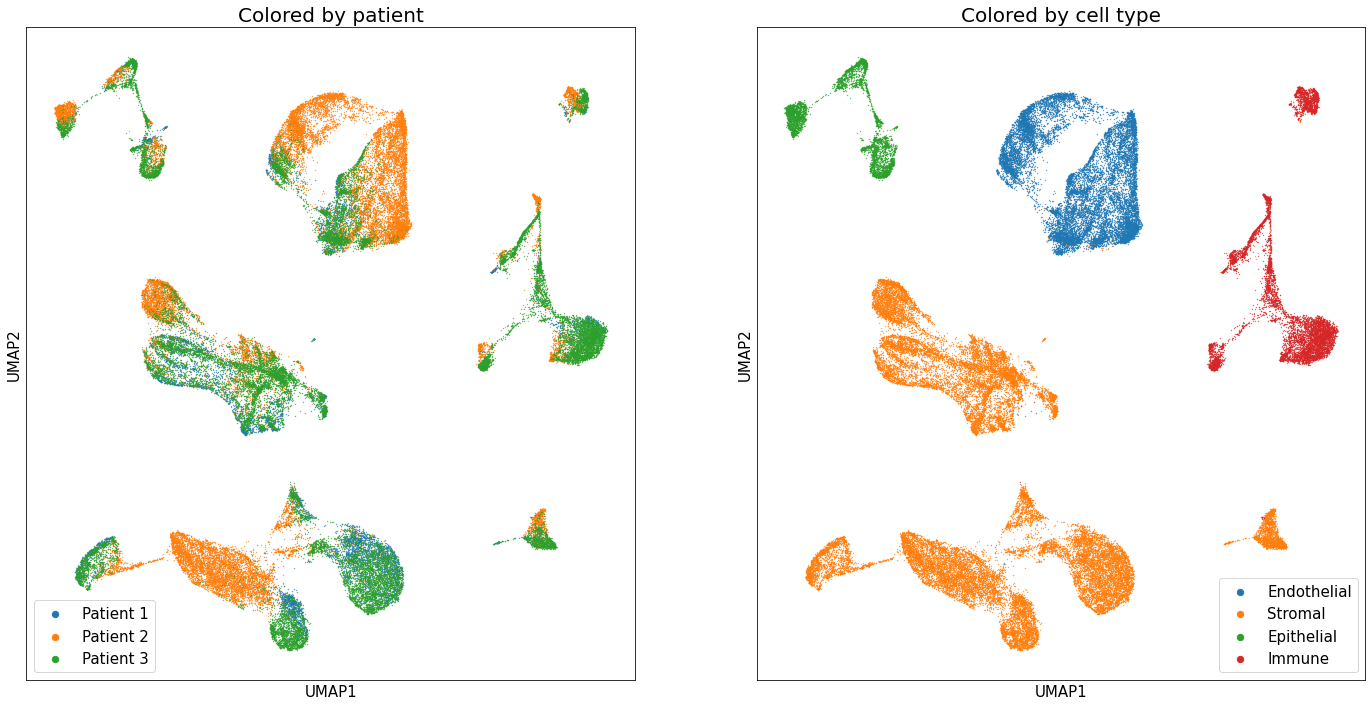

In [25]:
plot_datasets(
    {
        "X": X1,
        "labels": lbl1,
        "name": "Patient 1"
    },
    {
        "X": X2,
        "labels": lbl2,
        "name": "Patient 2"
    },
    {
        "X": X3,
        "labels": lbl3,
        "name": "Patient 3"
    },
)

As we can see, datasets are already quite cluster per cell type. Nonetheless, they are subclustered by patient type. Let us see if transmorph can get rid of this inter-specific variability. We choose dataset 2 as the reference, as this is the largest dataset.

## II. Using transmorph to integrate cell type

### 1. Default parameters do not handle such dataset size

We start by trying with a default transmorph.

In [55]:
from transmorph import Transmorph

X1_integrated = Transmorph().fit_transform(X1, X2)

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 1000000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/risitop/.local/share/virtualenvs/transmorph-XhEokvZw/lib/python3.9/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


As we can see, the code runs for a while and spits some red text, not a good sign: datasets are too large for default parameters. We need to tune a little bit our method in order to make it work.

### 2. Parametrizing transmorph for large datasets

Three parameters are crucial for such large scale example. First, compute the cost matrix in a PC-space, setting **n\_comps** to something between 5 and 30. **n\_hops** allows for a dataset downsampling during optimal transport, greatly helping with such large datasets. Finally, enabling feature normalization is useful in high dimensional cases, where features can be quite different in terms of magnitude.

In [4]:
from transmorph import Transmorph

transmorph_large_scale = Transmorph(
    n_comps=15,  # Reducing data dimensionality helps building cost matrix
    n_hops=1,  # turning this on is crucial for scalability
    normalize=True  # this greatly helps for high dimensional data
)

In [5]:
t_start = time.time()
X1_integrated = transmorph_large_scale.fit_transform(X1, X2, jitter_std=.04)
print("Elapsed:", time.time() - t_start, "seconds")

t_start = time.time()
X3_integrated = transmorph_large_scale.fit_transform(X3, X2, jitter_std=.04)
print("Elapsed:", time.time() - t_start, "seconds")

Elapsed: 27.33434748649597 seconds
Elapsed: 44.559319257736206 seconds


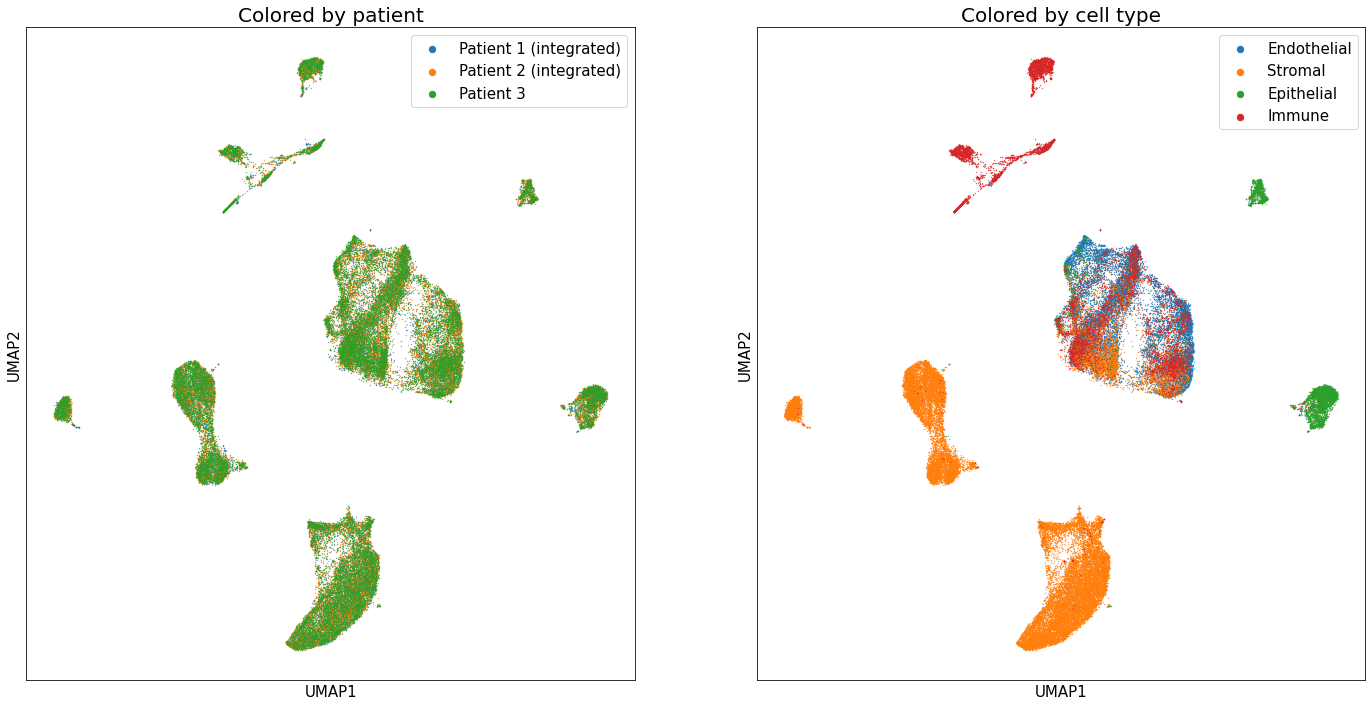

In [6]:
plot_datasets(
    {
        "X": X1_integrated,
        "labels": lbl1,
        "name": "Patient 1 (integrated)"
    },
    {
        "X": X2,
        "labels": lbl2,
        "name": "Patient 2 (integrated)"
    },
    {
        "X": X3_integrated,
        "labels": lbl3,
        "name": "Patient 3"
    },
)

Good news is, with these settings the transmorph is able to converge in a very reasonable time (<1min). But as we can see, cell types are completely mixed up after integration. This is often due to cell type unbalance between datasets, we have to adjust parameter with respect to this.

### 3. Tuning transmorph

Let us use the unbalanced formulation for this dataset. Both regularization parameters (entropy + marginal penalty) need to be tuned, bad tuning usually leading to convergence issues or poor integration.

In [7]:
from transmorph import Transmorph

transmorph_tuned = Transmorph(
    n_comps=15,
    n_hops=1,
    normalize=True,
    entropy=True,  # entropy regularization is necessary for unbalanced cases
    hreg=3e-4,  # <- entropy regularizer, needs tuning
    unbalanced=True,  # dealing with cell type unbalance
    mreg=1e-2  # <- marginal penalty, needs tuning
)

In [8]:
t_start = time.time()
X1_integrated_tuned = transmorph_tuned.fit_transform(X1, X2, jitter_std=.04)
print("Elapsed:", time.time() - t_start, "seconds")

t_start = time.time()
X3_integrated_tuned = transmorph_tuned.fit_transform(X3, X2, jitter_std=.04)
print("Elapsed:", time.time() - t_start, "seconds")

Elapsed: 21.236513376235962 seconds
Elapsed: 41.64520287513733 seconds


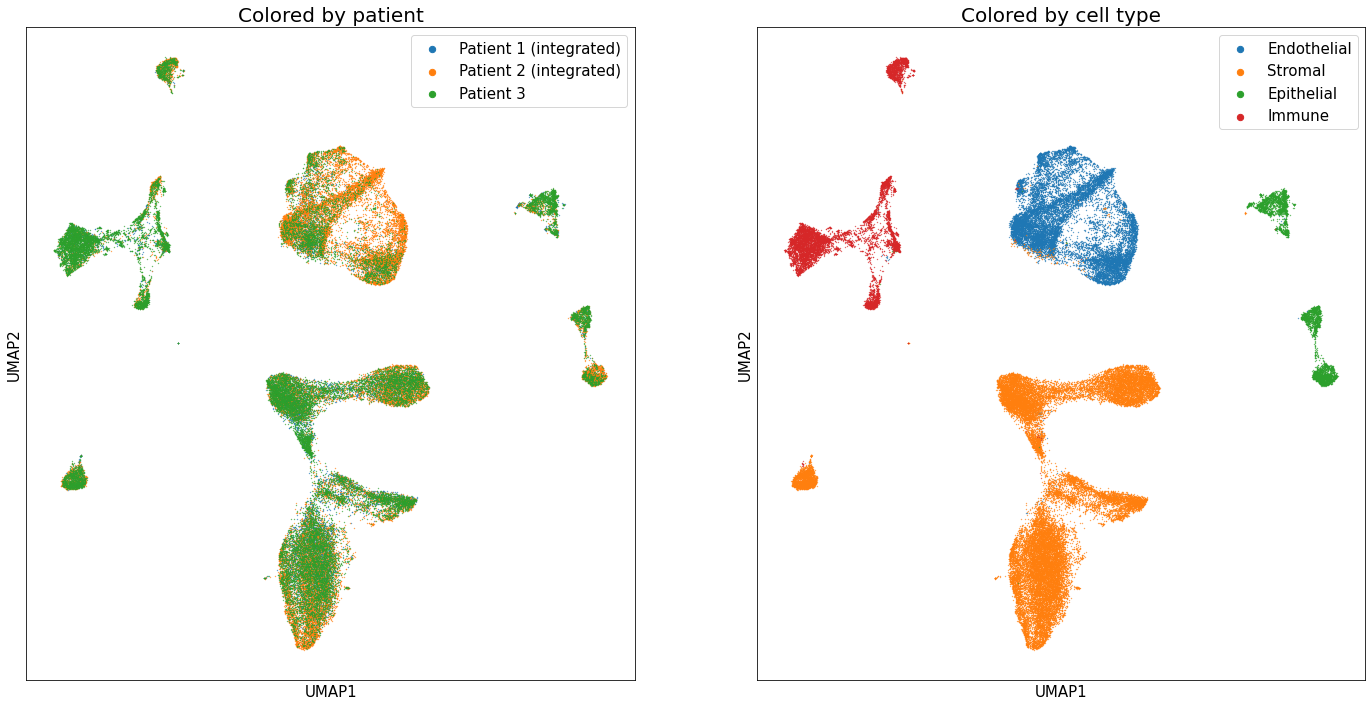

In [9]:
plot_datasets(
    {
        "X": X1_integrated_tuned,
        "labels": lbl1,
        "name": "Patient 1 (integrated)"
    },
    {
        "X": X2,
        "labels": lbl2,
        "name": "Patient 2 (integrated)"
    },
    {
        "X": X3_integrated_tuned,
        "labels": lbl3,
        "name": "Patient 3"
    },
)

As we can see, using unbalanced formulation greatly helped in this case, and we recover a great integration quality with much less patient-based subclustering in a very reasonable time (<1min). We hope this tutorial helped you understanding transmorph's capabilities to deal with large, high dimensional datasets.

# III. References

**[1]** Travaglini et al., *A molecular cell atlas of the human lung from single-cell RNA sequencing*, **Nature 2020**

**[2]** McInnes, L, Healy, J, *UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction*, **ArXiv e-prints 1802.03426, 2018**